In [1]:
import sys
sys.path.append('..')
from main import *
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [10]:
def get_env_and_rollouts(env_name='DoorKeyEnv<MiniGrid-DoorKey-8x8-v0>'):
    twenty_perfect_rollouts = pickle.load(open('../teacher_rollouts/teacher_rollouts_<{0}>.pkl'.format(env_name),
                                               'rb'
                                              )
                                         )
    rollouts = [Rollout(obs=rol[0], action=rol[1]) for rol in twenty_perfect_rollouts]
    env = gym.make(env_name[env_name.find('<')+1:env_name.rfind('>')])
    return rollouts, env

In [13]:
rollouts, env = get_env_and_rollouts('MultiRoomEnvN6<MiniGrid-MultiRoom-N6-v0>')

In [14]:
len(rollouts)

25

In [15]:
print_freq = {1000: (0, 9, 49, 99, 199, 499, 749, 999),
              100: (0, 9, 24, 49, 74, 99),
              50: (0, 9, 19, 29, 39, 49),
              10: (0, 3, 6, 9)}

In [46]:
def retrain(model, train_set, n_epochs=100, print_stuff=True):
    for i in range(0, n_epochs):
        total_loss = 0
        for r in train_set:
            total_loss += train_model(model, r)
        if print_stuff and i in print_freq[n_epochs]:
            print("loss at epoch {0}: {1}".format(i + 1,
                                                  total_loss / len(train_set)
                                                 ))
curr_seed = 0
def test_on_new(env, model,
                n_tests=1000,
                eps=0,
                sample=True):
    global curr_seed
    n_ok = 0.
    for _ in range(n_tests):
        #different seed = different env
        new_rollout = run_model(model, env,
                                seed=curr_seed,
                                eps=eps,
                                sample=sample)
        n_ok += new_rollout.total_reward > 0
        curr_seed += 1
    return n_ok/n_tests

def train_multiple_epochs(env, n_epochs, train_set, model, n_tests=200,
                          eps=0, print_meta_stuff=True, print_stuff=False, return_train=False):
    successes_sample = []
    successes_argmax = []
    for k in range(int(n_epochs/50) + 1):
        succ_sample = test_on_new(env, model, n_tests, eps, True)
        succ_argmax = test_on_new(env, model, n_tests, eps, False)
        if print_meta_stuff:
            print("succes rate at epoch {0}: (sample: {1}, argmax: {2}) out of {3} tests".format(k*50, succ_sample, succ_argmax, n_tests))
        successes_sample.append(succ_sample)
        successes_argmax.append(succ_argmax)
        if k == int(n_epochs/50):
            break
        retrain(model, train_set, 50, print_stuff=print_stuff)
    out_dic = {'successes_sample': successes_sample,
               'successes_argmax': successes_argmax}
    return out_dic

In [54]:
def analyze(env_name='DoorKeyEnv<MiniGrid-DoorKey-8x8-v0>',
            n_tests=400,
            n_epochs=200,
            arch='cnn'):
    rollouts, env = get_env_and_rollouts(env_name)
    print("")
    print("{0} available training rollouts for {1}".format(len(rollouts), env_name))
    out_dic = {}
    for r in (0.2, 0.4, 0.6, 0.8, 1):
        model = Model(env.observation_space.spaces['image'].shape,
                  env.action_space.n,
                  arch=arch)
        print("Training with {0}% of {1} rollouts ({2})".format(100 * r, len(rollouts), int(r * len(rollouts))))
        out_dic[int(r * len(rollouts))] = train_multiple_epochs(env, n_epochs, rollouts[:int(r * len(rollouts))], model, n_tests)
    return out_dic

In [55]:
out_dic = {}

In [56]:
for env in ('DoorKeyEnv6x6<MiniGrid-DoorKey-6x6-v0>',
           'DoorKeyEnv<MiniGrid-DoorKey-8x8-v0>',
           'EmptyEnv16x16<MiniGrid-Empty-16x16-v0>',
           'EmptyEnv6x6<MiniGrid-Empty-6x6-v0>',
           'EmptyEnv<MiniGrid-Empty-8x8-v0>',
           'MultiRoomEnvN2S4<MiniGrid-MultiRoom-N2-S4-v0>',
           'MultiRoomEnvN6<MiniGrid-MultiRoom-N6-v0>'):
    out_dic[env+'cnn'] = analyze(env_name = env, arch='cnn')
    pickle.dump(out_dic, open('out_dic.pkl', 'wb'))
    out_dic[env+'mlp'] = analyze(env_name = env, arch='mlp')
    pickle.dump(out_dic, open('out_dic.pkl', 'wb'))


14 available training rollouts for DoorKeyEnv6x6<MiniGrid-DoorKey-6x6-v0>
Training with 20.0% of 14 rollouts (2)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.045, argmax: 0.055) out of 400 tests
succes rate at epoch 100: (sample: 0.06, argmax: 0.055) out of 400 tests
succes rate at epoch 150: (sample: 0.0625, argmax: 0.0475) out of 400 tests
succes rate at epoch 200: (sample: 0.0575, argmax: 0.05) out of 400 tests
Training with 40.0% of 14 rollouts (5)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.3775, argmax: 0.3425) out of 400 tests
succes rate at epoch 100: (sample: 0.45, argmax: 0.3275) out of 400 tests
succes rate at epoch 150: (sample: 0.4025, argmax: 0.2925) out of 400 tests
succes rate at epoch 200: (sample: 0.3975, argmax: 0.3025) out of 400 tests
Training with 60.0% of 14 rollouts (8)
succes rate at epoch 0: (sample: 0.0025, argmax: 0.0) out of 400 tests
succ

succes rate at epoch 150: (sample: 0.36, argmax: 0.385) out of 400 tests
succes rate at epoch 200: (sample: 0.4775, argmax: 0.375) out of 400 tests

3 available training rollouts for EmptyEnv16x16<MiniGrid-Empty-16x16-v0>
Training with 20.0% of 3 rollouts (0)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 100: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 150: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 200: (sample: 0.0, argmax: 0.0) out of 400 tests
Training with 40.0% of 3 rollouts (1)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.2325, argmax: 0.0) out of 400 tests
succes rate at epoch 100: (sample: 0.4225, argmax: 0.0) out of 400 tests
succes rate at epoch 150: (sample: 0.4825, argmax: 0.0) out of 400 tests
succes rate at epoch 200: (sample: 0.49, argmax: 0.0) out of 400 test

succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 100: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 150: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 200: (sample: 0.0, argmax: 0.0) out of 400 tests
Training with 40.0% of 3 rollouts (1)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 0.9925, argmax: 1.0) out of 400 tests
succes rate at epoch 100: (sample: 1.0, argmax: 1.0) out of 400 tests
succes rate at epoch 150: (sample: 1.0, argmax: 1.0) out of 400 tests
succes rate at epoch 200: (sample: 1.0, argmax: 1.0) out of 400 tests
Training with 60.0% of 3 rollouts (1)
succes rate at epoch 0: (sample: 0.0, argmax: 0.0) out of 400 tests
succes rate at epoch 50: (sample: 1.0, argmax: 1.0) out of 400 tests
succes rate at epoch 100: (sample: 1.0, argmax: 1.0) out of 400 tests
succes rate at epoch

RuntimeError: invalid argument 2: invalid multinomial distribution (sum of probabilities <= 0) at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/TH/generic/THTensorRandom.c:285

In [61]:
out_dic

{'DoorKeyEnv6x6<MiniGrid-DoorKey-6x6-v0>cnn': {2: {'successes_argmax': [0.0,
    0.055,
    0.055,
    0.0475,
    0.05],
   'successes_sample': [0.0, 0.045, 0.06, 0.0625, 0.0575]},
  5: {'successes_argmax': [0.0, 0.3425, 0.3275, 0.2925, 0.3025],
   'successes_sample': [0.0, 0.3775, 0.45, 0.4025, 0.3975]},
  8: {'successes_argmax': [0.0, 0.37, 0.3725, 0.3375, 0.3875],
   'successes_sample': [0.0025, 0.435, 0.4525, 0.4575, 0.415]},
  11: {'successes_argmax': [0.0, 0.48, 0.4725, 0.5, 0.4775],
   'successes_sample': [0.0, 0.4775, 0.525, 0.5525, 0.47]},
  14: {'successes_argmax': [0.0, 0.5875, 0.5675, 0.5175, 0.5125],
   'successes_sample': [0.0, 0.655, 0.645, 0.62, 0.625]}},
 'DoorKeyEnv6x6<MiniGrid-DoorKey-6x6-v0>mlp': {2: {'successes_argmax': [0.0,
    0.0375,
    0.0175,
    0.0275,
    0.035],
   'successes_sample': [0.0, 0.0325, 0.0275, 0.04, 0.0325]},
  5: {'successes_argmax': [0.0, 0.315, 0.3075, 0.325, 0.3],
   'successes_sample': [0.0, 0.3875, 0.3825, 0.415, 0.3825]},
  8: {'succ

In [65]:
a = out_dic['DoorKeyEnv6x6<MiniGrid-DoorKey-6x6-v0>cnn']

In [80]:
a

{5: {'successes_argmax': [0.0, 0.0, 0.0, 0.0, 0.0],
  'successes_sample': [0.0, 0.0, 0.0, 0.0025, 0.0]},
 10: {'successes_argmax': [0.0, 0.0, 0.0, 0.0, 0.0025],
  'successes_sample': [0.0, 0.0075, 0.0, 0.005, 0.0]},
 15: {'successes_argmax': [0.0, 0.0, 0.0025, 0.0025, 0.0025],
  'successes_sample': [0.0, 0.01, 0.0075, 0.02, 0.01]},
 20: {'successes_argmax': [0.0, 0.015, 0.015, 0.015, 0.03],
  'successes_sample': [0.0, 0.0425, 0.04, 0.0575, 0.055]},
 25: {'successes_argmax': [0.0, 0.0125, 0.0175, 0.0125, 0.01],
  'successes_sample': [0.0, 0.0575, 0.06, 0.03, 0.055]}}

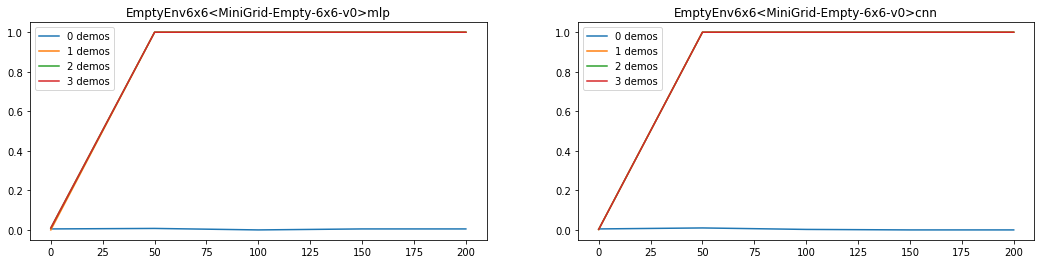

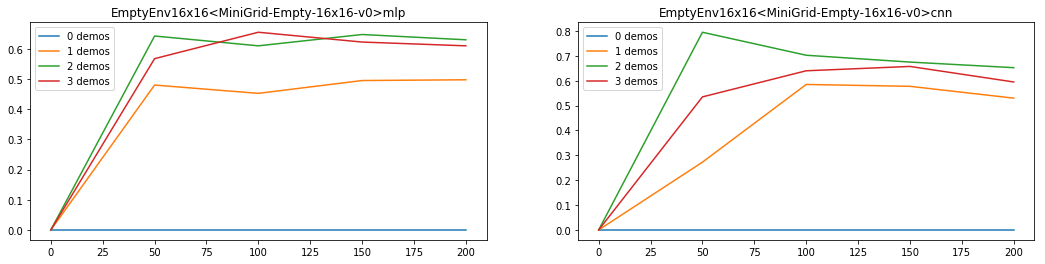

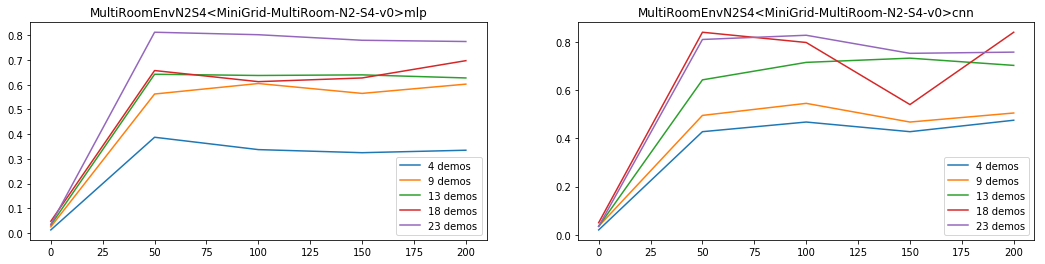

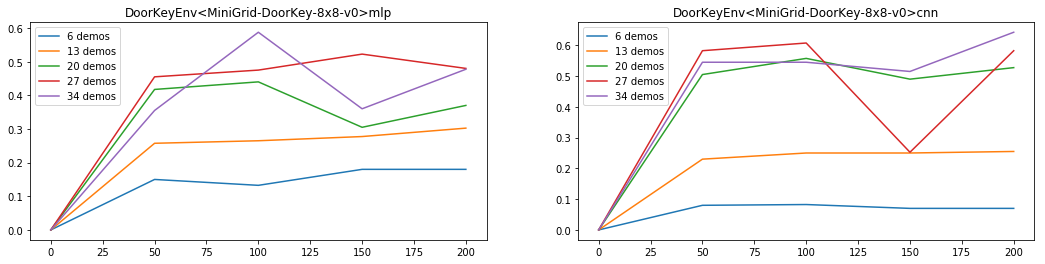

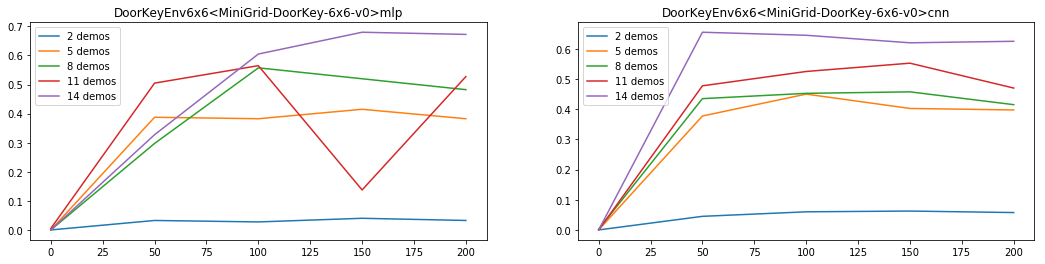

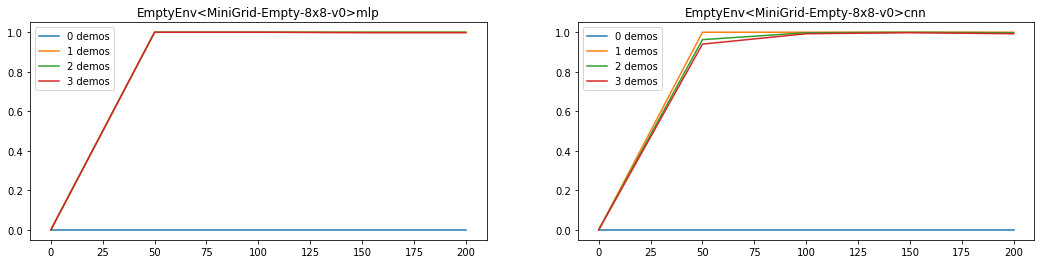

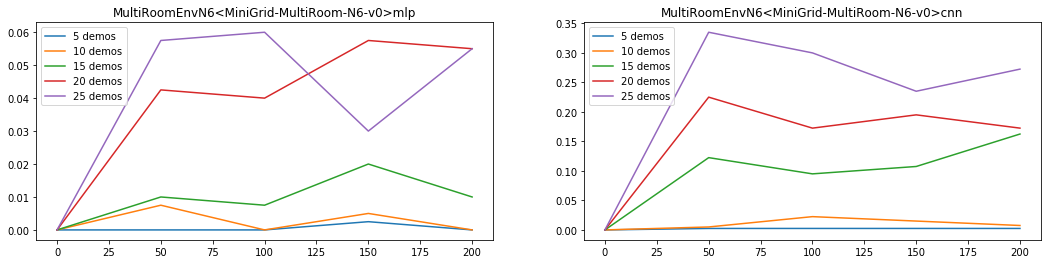

In [92]:
plt.rcParams['figure.figsize'] = (18, 4)
all_env_names = set([name[:-3] for name in out_dic.keys()])
for env_name in all_env_names:
    fig, axes = plt.subplots(1, 2)
    for k, v in out_dic[env_name + 'mlp'].items():
        for k2, v2 in v.items():
            if 'sample' in k2:
                axes[0].plot([0, 50, 100, 150, 200], v2, label='{0} demos'.format(k))
        axes[0].legend()
        axes[0].set_title(env_name + 'mlp')
    for k, v in out_dic[env_name + 'cnn'].items():
        for k2, v2 in v.items():
            if 'sample' in k2:
                axes[1].plot([0, 50, 100, 150, 200], v2, label='{0} demos'.format(k))
        axes[1].legend()
        axes[1].set_title(env_name + 'cnn')

    plt.show()